In [2]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [27]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

available = []
pool=[]

#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk("/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True
            
####### normalise the count rates! think about the effect of 0-1 normalisation on the distance calculation
####### due to the energy integration in Std1 diefferences between different epochs shouldn't matter; there would be very few photons found at the extremes of the range            
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))


In [ ]:
    
lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])
lc_classes

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.5, random_state=0, stratify=classes_abu)

In [4]:
x_valid, x_test, y_valid, y_test, id_valid, id_test = train_test_split(x_test, y_test, id_test, test_size=0.5, random_state=0, stratify=y_test)

In [39]:
import segment_cluster as sc
import importlib
importlib.reload(sc)
pro_clusters=[100, 150, 200]
seg_lens=[30, 50, 70]
classes=set(y_train)
results=np.zeros((len(pro_clusters), len(seg_lens), len(classes), len(classes), 2))
for n_pro, proportion in enumerate(pro_clusters):
    for n_len, length in enumerate(seg_lens):
        for n_model, model_class in enumerate(classes):

            ##train the model
            time_stamps=False
            offset=True
            training_ys=np.where(np.array(y_train)=='{}'.format(model_class))[0]
            all_train_segments=[]
            for ts_i in training_ys:
                ts=x_train[ts_i]
                train_segments=sc.segmentation(ts, length, 2, time_stamps=time_stamps)
                c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
                all_train_segments.append(c_train_segments)
            all_train_segments=np.vstack(all_train_segments)
            if proportion > len(all_train_segments): proportion = len(all_train_segments)
            #cluster=KMeans(n_clusters=int(proportion*len(all_train_segments)), random_state=0)
            cluster=KMeans(n_clusters=proportion, random_state=0)
            cluster.fit(all_train_segments)
            
            ##test against the validation set
            for n_test, test_class in enumerate(classes):
                testing_ys=np.where(np.array(y_valid)=='{}'.format(test_class))[0]
                time_stamps=True
                offset=False
                reco_error=[]
                seg_len=length
                seg_slide=int(length*0.5)
                for ts_id in testing_ys:
                    test_ts=x_valid[ts_id]
                    test_segments= sc.segmentation(test_ts, seg_len, seg_slide, time_stamps=time_stamps)
                    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
                    reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)
                    error=np.sqrt(np.mean((test_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
                    reco_error.append((ts_id, error))
                results[n_pro, n_len, n_model, n_test, 0]=np.mean(np.array(reco_error)[:,1])
                results[n_pro, n_len, n_model, n_test, 1]=np.std(np.array(reco_error)[:,1])
                print(n_pro, n_len, n_model, n_test, results[n_pro, n_len, n_model, n_test, 0], results[n_pro, n_len, n_model, n_test, 1], flush=True)

with open("model_errors.csv", "w") as outfile:
    for a, n_pro in enumerate(results):
        for b, n_len in enumerate(n_pro):
            for c, n_model in enumerate(n_len):
                outfile.write("#n_clusters: {}, n_segment_len: {}, n_training_class: {}\n".format(a,b,c))
                np.savetxt(outfile, n_model, delimiter=",") 

model trained on  rho  tested on  rho no segments  18669
0 0 0 0 218.04821374413683 20.45065700921662
model trained on  rho  tested on  mu no segments  18669
0 0 0 1 1076.046067490767 386.9537572254003
model trained on  rho  tested on  chi no segments  18669
0 0 0 2 116.36736383389724 46.68306469176364
model trained on  rho  tested on  kappa no segments  18669
0 0 0 3 738.373547570104 52.27473639937838
model trained on  rho  tested on  phi no segments  18669
0 0 0 4 133.79164770888002 50.84640183610094
model trained on  rho  tested on  alpha no segments  18669
0 0 0 5 174.21701647183474 64.25649990961088
model trained on  rho  tested on  beta no segments  18669
0 0 0 6 563.4575659550401 302.23301834309547
model trained on  rho  tested on  delta no segments  18669
0 0 0 7 367.5647519611143 67.71275043065302
model trained on  rho  tested on  theta no segments  18669
0 0 0 8 670.1572618200473 101.3634683664389
model trained on  rho  tested on  gamma no segments  18669
0 0 0 9 379.70195123

KeyboardInterrupt: 

In [148]:
from sklearn.cluster import KMeans
import segment_cluster as sc
import importlib
importlib.reload(sc)
cluster=KMeans(n_clusters=200, random_state=0)
time_stamps=False
offset=True

#lets try a theta doped set of beta time curves
beta_ys=np.where(np.array(y_train)=='beta')[0]
all_train_segments=[]
for ts_i in beta_ys:
    ts=x_train[ts_i]
    train_segments=sc.segmentation(ts, 50, 2, time_stamps=time_stamps)
    c_train_segments=sc.center_offset(train_segments, ts, offset=offset, time_stamps=time_stamps)
    all_train_segments.append(c_train_segments)
cluster.fit(np.array(c_train_segments))

#use the validation set to measure the reconstruction error difference between the same class observations and outliers
beta_ys=np.where(np.array(y_valid)=='beta')[0]
delta_ys=np.where(np.array(y_valid)=='delta')[0]
time_stamps=True
offset=False
reco_error=[]
seg_slide=25
seg_len=50
for ts_id in delta_ys:
    test_ts=x_valid[ts_id]
    test_segments= sc.segmentation(test_ts, seg_len, seg_slide, time_stamps=time_stamps)
    c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)
    reco = sc.reconstruct(test_segments, test_ts, cluster, rel_offset=offset)
    error=np.sqrt(np.mean((test_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
    reco_error.append((ts_id, error))

In [135]:
from sklearn.cluster import KMeans
import segment_cluster as sc
import importlib
importlib.reload(sc)

cluster=KMeans(n_clusters=100, random_state=0)
# training and test time series, both time[0] and count rate[1]
train_ts=x_train[5]
test_ts=x_train[5]

offset=True
time_stamps=True

#train the model
train_segments=sc.segmentation(train_ts, 100, 2, time_stamps=time_stamps)
c_train_segments=sc.center_offset(train_segments, train_ts, offset=offset, time_stamps=time_stamps)
cluster.fit(np.array(c_train_segments)[:,1])

#test segments
test_segments= sc.segmentation(test_ts, 100, 10, time_stamps=time_stamps)
c_test_segments=sc.center_offset(test_segments, test_ts, offset=offset, time_stamps=time_stamps)

#reconstruct the test time series
reco = sc.reconstruct(c_test_segments, test_ts, cluster, rel_offset=offset)

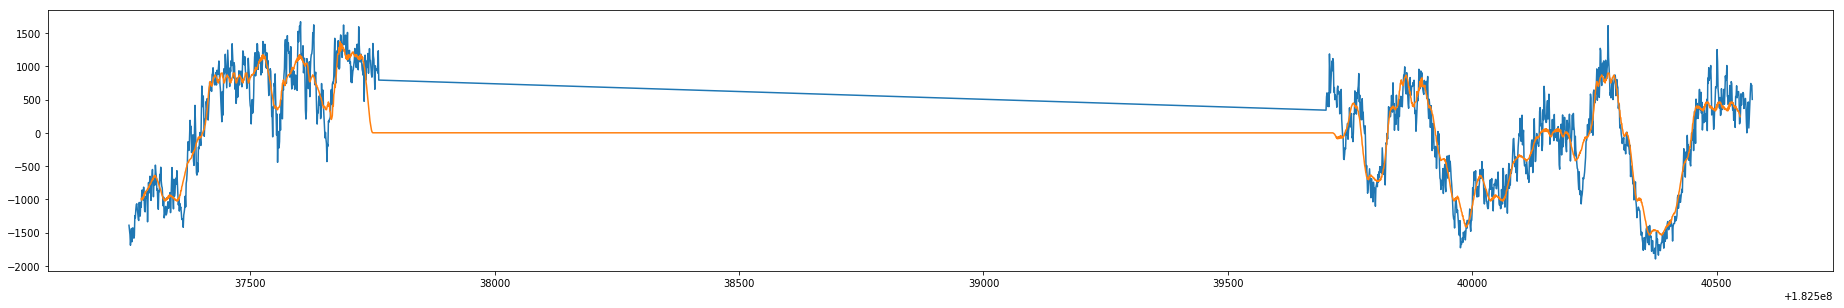

162.15347851464594


In [149]:
plt.figure(figsize=(6.4*5, 4.8))
plt.plot(test_ts[0],test_ts[1])
plt.plot(reco[0][25:-25],reco[1][25:-25])
#plt.plot(reco[0][25:-25], reco[1][25:-25]-test_ts[1][25:-25])
plt.show()
print(np.mean(reco_error))

In [6]:
#results[n_pro, n_len, n_model, n_test, 0]
in_results=np.zeros((3,3,10,10,2))
with open("hyperpar_experiment.txt", "r") as file:
    for line in file:
        if line[0] != "m":
            line = line[:-1]
            items=line.split(" ")
            in_results[int(items[0]), int(items[1]), int(items[2]), int(items[3]), 0]= np.round(float(items[4]),2)
            in_results[int(items[0]), int(items[1]), int(items[2]), int(items[3]), 1]= np.round(float(items[5]),2)

In [7]:
#results[n_pro, n_len, n_model, n_test, 0]
import pandas as pd
pro_clusters=[100, 150, 200]
seg_lens=[30, 50, 70]
classes=list(set(y_valid))
bad_models_c=np.zeros((3,3))
bad_models_m=np.zeros((3,3))
for c in range(3):
    print("cluster", pro_clusters[c])
    for l in range(3):
        neg_diffs_hyper=[]
        neg_counters=[]
        print("length", seg_lens[l])
        for m in range(10):
            print("model", classes[m])
            print("standard deviations:", in_results[c,l,m,:,1])
            print("self std:", in_results[c,l,m,m,1])
            differences=in_results[c,l,m,:,0]-in_results[c,l,m,m,0]
            counter=0
            neg_diffs_model=[]
            for d, diff in enumerate(differences):
                if diff<0:
                    if in_results[c,l,m,m,1]<np.max(in_results[c,l,m,:,1]):
                        neg_diffs_model.append(diff)
                        counter+=1
                    print("Model reconstructed {} l.c.s with smaller error ({}) than self. Std: {}".format(classes[d], diff, in_results[c,l,m,d,1]))
            neg_counters.append(counter)
            if len(neg_diffs_model)>0:
                neg_diffs_hyper.append(np.mean(np.array(neg_diffs_model)))
        bad_models_m[c,l]=np.mean(neg_diffs_hyper)
        bad_models_c[c,l]=np.mean(np.array(neg_counters))
        #print(pd.DataFrame(in_results[c,l,:,:,0], index=classes, columns=classes))


cluster 100
length 30
model phi
standard deviations: [ 87.24  41.3   61.35  38.59 127.06  35.16  38.51  70.49  62.99  73.78]
self std: 87.24
Model reconstructed delta l.c.s with smaller error (-127.70000000000002) than self. Std: 41.3
Model reconstructed kappa l.c.s with smaller error (-115.09) than self. Std: 38.59
Model reconstructed rho l.c.s with smaller error (-138.67000000000002) than self. Std: 35.16
Model reconstructed beta l.c.s with smaller error (-31.79000000000002) than self. Std: 38.51
model delta
standard deviations: [422.1   44.72 122.93  89.54 418.19  46.94  88.38 151.51  74.35 101.97]
self std: 44.72
Model reconstructed rho l.c.s with smaller error (-7.809999999999988) than self. Std: 46.94
model theta
standard deviations: [198.48  69.47  61.48  43.94  98.53  55.48  37.01  90.12  49.09  85.12]
self std: 61.48
Model reconstructed phi l.c.s with smaller error (-16.579999999999984) than self. Std: 198.48
Model reconstructed delta l.c.s with smaller error (-263.16999999999

In [197]:
neg_diffs_hyper

[-19.200000000000003,
 -229.7228571428572,
 -261.60111111111104,
 -158.4933333333333,
 -80.27666666666669,
 -184.60333333333332,
 -149.75166666666664]

In [8]:
d_df=pd.DataFrame(bad_models_m, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
ddd=[[np.nan, -148.487807508944, -154.04211310383596],[np.nan,np.nan,-151.78630005493704]]
ddd=pd.DataFrame(ddd,index=["30 clusters","300 clusters"], columns=["{}s segments".format(x) for x in seg_lens])
d_df=d_df.append(ddd)
d_df=d_df.reindex(["30 clusters","100 clusters","150 clusters","200 clusters","300 clusters"])
d_df["100s segments"]=pd.Series([np.nan,np.nan,np.nan,np.nan,-164.22376638765854])
d_df.set_value("300 clusters","100s segments",-164.22376638765854)
d_df

/home/jkok1g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,30s segments,50s segments,70s segments,100s segments
30 clusters,NaN,-148.487808,-154.042113,NaN
100 clusters,-109.900078,-132.216746,-152.101048,NaN
150 clusters,-109.318282,-147.076208,-142.675982,NaN
200 clusters,-105.828247,-142.032905,-154.806995,NaN
300 clusters,NaN,NaN,-151.786300,-164.223766


In [9]:
c_df=pd.DataFrame(bad_models_c, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
ddd=[[np.nan, 3.7, 3.9],[np.nan,np.nan,3.6]]
ddd=pd.DataFrame(ddd,index=["30 clusters","300 clusters"], columns=["{}s segments".format(x) for x in seg_lens])
c_df=c_df.append(ddd)
c_df=c_df.reindex(["30 clusters","100 clusters","150 clusters","200 clusters","300 clusters"])
c_df["100s segments"]=pd.Series([np.nan,np.nan,np.nan,np.nan,3.5])
c_df.set_value("300 clusters","100s segments",3.5)
c_df

/home/jkok1g14/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


,30s segments,50s segments,70s segments,100s segments
30 clusters,NaN,3.7,3.9,NaN
100 clusters,3.7,3.3,3.2,NaN
150 clusters,3.7,3.5,3.3,NaN
200 clusters,3.6,3.5,3.2,NaN
300 clusters,NaN,NaN,3.6,3.5


In [217]:
#np.shape(np.loadtxt("model_errors_20190125.csv", delimiter=",")) (200, 2)
errors_1=np.loadtxt("model_errors_20190125.csv", delimiter=",")
errors_2=np.loadtxt("model_errors_20190125_2.csv", delimiter=",")
c300l70=errors_1[:100].reshape((10,10,2))#3.6, -151.78630005493704
c300l100=errors_1[100:].reshape((10,10,2))#3.5, -164.22376638765854
c30l50=errors_2[:100].reshape((10,10,2))#3.7, -148.487807508944
c30l70=errors_2[100:].reshape((10,10,2))#3.9, -154.04211310383596
counts=[]
mean_diffs=[]
for m, model in enumerate(c30l70):
    zeroed=model[:,0]-model[m,0]
    counter=0
    diffs=[]
    for z in zeroed:
        if z<0:
            counter+=1
            diffs.append(z)
    counts.append(counter)
    if len(diffs):
        mean_diffs.append(np.mean(np.array(diffs)))

In [218]:
np.mean(np.array(mean_diffs))

-154.04211310383596

In [219]:
np.mean(np.array(counts))

3.9

In [19]:
import pandas as pd
pro_clusters=[30,100,150,200]
seg_lens=[30,50,70,100,150]
#results[n_pro, n_len, n_model, n_test, 0]  3 4 9 9, 
data=np.loadtxt("/home/jkok1g14/Documents/model_errors.csv", delimiter=",")
np.shape(data)
data_fold=data.reshape((4,5,10,10,2))
data_fold
neg_counts=np.zeros((4,5))
neg_means=np.zeros((4,5))
for c, cluster in enumerate(data_fold):
    for l, length in enumerate(cluster):
        model_counts=np.zeros(10)
        model_means=np.zeros(10)
        for m, model in enumerate(length):
            centered=model[:,0]-model[m,0]
            counter=0
            neg_sum=0
            for t, test in enumerate(centered):
                
                if test<0 and model[t,1] < np.max(model[:,1]):
                    counter+=1
                    neg_sum+=test
                    #print(neg_sum)
            if counter >0:
                model_counts[m]=counter
                model_means[m]=neg_sum
        #print(model_counts)
        neg_counts[c,l]=np.mean(model_counts)
        neg_means[c,l]=np.mean(model_means)
counts_df=pd.DataFrame(neg_counts, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])
means_df=pd.DataFrame(neg_means, columns=["{}s segments".format(x) for x in seg_lens], index=["{} clusters".format(x) for x in pro_clusters])

In [20]:
counts_df

,30s segments,50s segments,70s segments,100s segments,150s segments
30 clusters,3.5,3.4,3.6,3.7,3.7
100 clusters,3.4,3.3,3.4,3.5,3.7
150 clusters,3.4,3.2,3.4,3.5,3.6
200 clusters,3.4,3.2,3.4,3.4,3.6


In [21]:
means_df

,30s segments,50s segments,70s segments,100s segments,150s segments
30 clusters,-532.470479,-713.452158,-788.811354,-1034.577916,-1082.081864
100 clusters,-510.924391,-601.480725,-739.511996,-834.450874,-926.736661
150 clusters,-500.994429,-614.116743,-728.809691,-793.031372,-877.225624
200 clusters,-490.995233,-614.821080,-653.886793,-762.168314,-886.373160


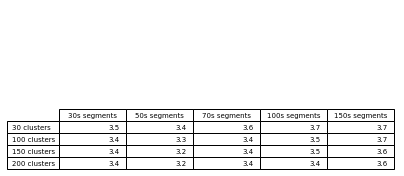

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import table

ax = plt.subplot(211, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, counts_df)  # where df is your data frame

plt.savefig('counts_table.png')